In [3]:
import pandas as pd
import numpy as np

In [4]:
df=pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Check for null values

In [5]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

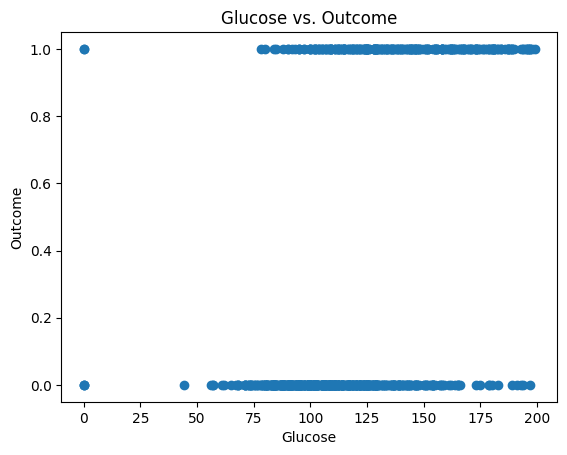

In [6]:
#Corr between Gulcose and Outcome
import matplotlib.pyplot as plt


# Plotting
plt.scatter(df['Glucose'], df['Outcome'])
plt.xlabel('Glucose')
plt.ylabel('Outcome')
plt.title('Glucose vs. Outcome')
plt.show()
#As we can see there is almost no differ


### From the above plot we can say that 

## For Outcome 1
####  The gulcose levels are spread across a rnge of 50 to 200. However, there is a noticeable concentration of points at higer gulcose levels, roughly between 100 and 175.

## For Outcome 0
### The gulcose levels are also spread across similar range. However,
### there is a noticable concentration of points at lower gulcose levels,  particularly between 50 and 150.


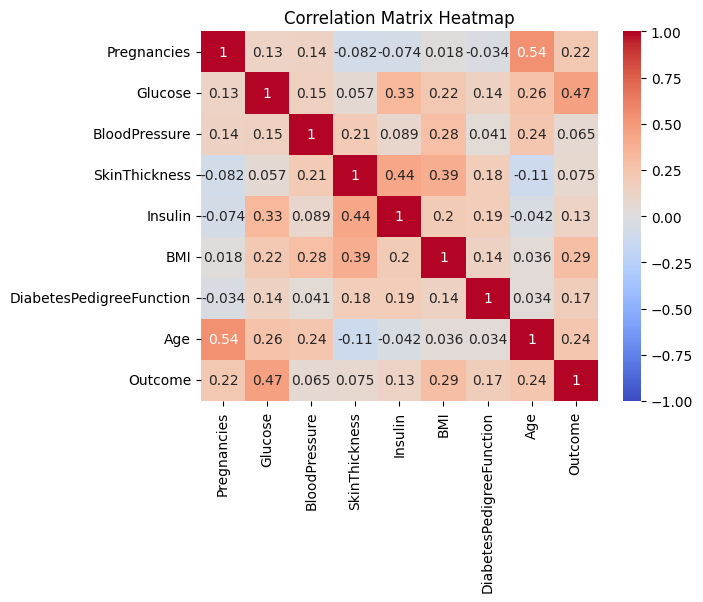

<Figure size 1000x800 with 0 Axes>

In [7]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1) 
plt.title('Correlation Matrix Heatmap')
plt.figure(figsize=(10, 8))
plt.show()

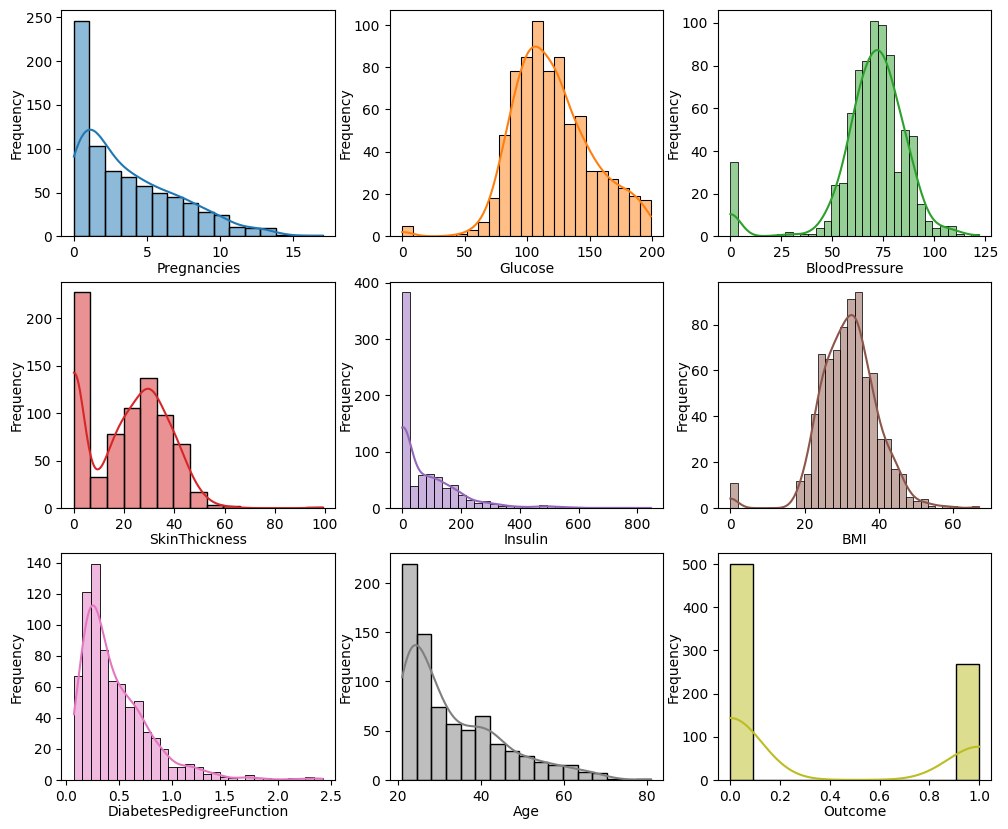

In [8]:
colors = sns.color_palette("tab10")
fig, ax = plt.subplots(3,3, figsize = (12,10))
for col, axes, color in zip(df.columns, ax.reshape(-1), colors[:9]):
    sns.histplot(data = df, x = col, ax = axes, kde = True, color = color)
    axes.set_ylabel('Frequency', labelpad = 1.0)
    axes.set_xlabel(col, labelpad = 1.0)
plt.show()

In [9]:
df.corr()["Outcome"].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

In [10]:
X=df.drop("Outcome",axis='columns')
y=df.Outcome

In [11]:
#Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler 

columns=["Glucose","BMI","Age"]

preprocessor = ColumnTransformer(
        transformers=[  
            ('numeric', StandardScaler(),columns)
        ]
    )

In [13]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
models = {
            'HistGradientBoosting':{
            'model':HistGradientBoostingClassifier(class_weight='balanced'),
            'params':{
                'histgradientboostingclassifier__max_iter':[200,300]
            }
        },
        
        'RandomForest': {
            'model': RandomForestClassifier(),
            'params': {
                'randomforestclassifier__n_estimators': [100, 200],
                'randomforestclassifier__max_depth': [20, 30],
                'randomforestclassifier__class_weight': ['balanced']
            }
            },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'kneighborsclassifier__n_neighbors': [3, 5, 7],
                'kneighborsclassifier__weights': ['uniform', 'distance']
            },
        
        },
        'LogisticRegression': {
            'model': LogisticRegression(max_iter=1000),
            'params': {
                'logisticregression__C': [0.1, 1, 10],
                'logisticregression__class_weight': ['balanced']
                }
            }  
        }

In [14]:
from sklearn.pipeline import make_pipeline
best_models = {}
for name, mp in models.items():
    pipeline = make_pipeline(preprocessor, mp['model'])
    grid = GridSearchCV(pipeline, param_grid=mp['params'], scoring='f1', cv=4, return_train_score=False,n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(name)
    print(grid.best_params_)

    
voting_estimators = [(name, model) for name, model in best_models.items()]
clf = VotingClassifier(estimators=voting_estimators, voting='soft')
clf.fit(X_train, y_train)

HistGradientBoosting
{'histgradientboostingclassifier__max_iter': 200}
RandomForest
{'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__n_estimators': 200}
KNN
{'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__weights': 'uniform'}
LogisticRegression
{'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced'}


VotingClassifier(estimators=[('HistGradientBoosting',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('numeric',
                                                                                StandardScaler(),
                                                                                ['Glucose',
                                                                                 'BMI',
                                                                                 'Age'])])),
                                              ('histgradientboostingclassifier',
                                               HistGradientBoostingClassifier(class_weight='balanced',
                                                                              max_iter=200))])),
                             ('RandomForest',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransf...
                                                                                StandardScaler(),
                                                                                ['Glucose',
                                                                                 'BMI',
                                                                                 'Age'])])),
                                              ('kneighborsclassifier',
                                               KNeighborsClassifier(n_neighbors=7))])),
                             ('LogisticRegression',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('numeric',
                                                                                StandardScaler(),
                                                                                ['Glucose',
                                                                                 'BMI',
                                                                                 'Age'])])),
                                              ('logisticregression',
                                               LogisticRegression(C=0.1,
                                                                  class_weight='balanced',
                                                                  max_iter=1000))]))],
                 voting='soft')

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        92
           1       0.75      0.65      0.70        62

    accuracy                           0.77       154
   macro avg       0.77      0.75      0.76       154
weighted avg       0.77      0.77      0.77       154



In [17]:
import pickle

# Saving the model to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(clf, f)